# Graph Neural Networks for SMall Molecule Regression
_by David Holmberg (August 2023)_
#### Dataset
For this exercise we will use the same dataset of aqueous solubility of 1142 diverse chemical compounds.

#### Modelling comparisons
1. Compare the results of linear regression to those of Graph Neural Networks

#### Aims
* Introduce the concept of Graph Neural Networks
* Introduce PyTorch code for GNNs


## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Pytorch and Pytorch Geometric
import torch as tch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.nn import GCNConv, GATConv, summary as gsummary, global_mean_pool, global_max_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import dropout_adj

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski


# Helper libraries
from torchsummary import summary as asummary
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# device = tch.device("cuda" if tch.cuda.is_available() else "cpu")
tch.backends.cudnn.enabled = False
tch.cuda.is_available = lambda : False
device = tch.device('cuda')

RDKit WARNING: [14:16:09] Enabling RDKit 2019.09.1 jupyter extensions
[14:16:09] Enabling RDKit 2019.09.1 jupyter extensions


## functions
Run these cells to have access to the necessary functions for the lab. Highly encouraged that you read through it and understand, though not necessary for the aims of this lab.

In [2]:


def plot_history(train_losses, val_losses, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(train_losses)
    ax.plot(val_losses)
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    ax = fig.add_subplot(122)
    ax.plot(np.log(train_losses))
    ax.plot(np.log(val_losses))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()
#Set morgan to 3 or 4 and nBits to 1024
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return list(fp.ToBitString())

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
    return mol

def read_smiles_data(path_data):
    df = pd.read_csv(path_data, sep=',')
    df['fingerprint'] = df['SMILES'].apply(smiles_to_fingerprint)
    df['fingerprint'] = df['fingerprint'].apply(lambda x: [int(bit) for bit in x])
    df['fingerprint'] = df['fingerprint'].apply(lambda x: np.array(x))
    df['mol'] = df['SMILES'].apply(smiles_to_mol)
    return df

def is_hydrogen_donor(atomic_num, hybridization):
    return int((atomic_num == 8 or atomic_num == 7) and (hybridization == 3 or hybridization == 2))

def is_polar_bond(atom1_num, atom2_num, electronegativity):
    en1 = electronegativity.get(atom1_num, None)
    en2 = electronegativity.get(atom2_num, None)
    if en1 is None or en2 is None:
        return 0  # Unknown electronegativity, consider as non-polar
    return int(abs(en1 - en2) > 0.4)

def electroneg():
    return {
    1: 2.20,  # H
    3: 0.98,  # Li
    4: 1.57,  # Be
    5: 2.04,  # B
    6: 2.55,  # C
    7: 3.04,  # N
    8: 3.44,  # O
    9: 3.98,  # F
    11: 0.93, # Na
    12: 1.31, # Mg
    13: 1.61, # Al
    14: 1.90, # Si
    15: 2.19, # P
    16: 2.58, # S
    17: 3.16, # Cl
    19: 0.82, # K
    20: 1.00, # Ca
    22: 1.54, # Ti
    24: 1.66, # Cr
    25: 1.55, # Mn
    26: 1.83, # Fe
    27: 1.88, # Co
    28: 1.91, # Ni
    29: 1.90, # Cu
    30: 1.65, # Zn
    35: 2.96, # Br
    53: 2.66, # I
}

def weights_init(m):
    if isinstance(m, (GCNConv, GATConv)):
        nn.init.xavier_uniform_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

def make_pyg(row):
    # Create node features
    mol = row['mol']
    pauling = electroneg()
    atom_num = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atom_hyb = [int(atom.GetHybridization()) for atom in mol.GetAtoms()]
    atom_deg = [atom.GetDegree() for atom in mol.GetAtoms()]
    atom_arom = [int(atom.GetIsAromatic()) for atom in mol.GetAtoms()]  # Aromaticity
    # atom_hydrogens = [atom.GetTotalNumHs() for atom in mol.GetAtoms()]  # Number of hydrogens
    atom_h_donor = [is_hydrogen_donor(num, hyb) for num, hyb in zip(atom_num, atom_hyb)]
    atom_charge = [atom.GetFormalCharge() for atom in mol.GetAtoms()]  # Formal charge
    atom_chiral_tag = [int(atom.GetChiralTag()) for atom in mol.GetAtoms()]  # Chirality
    atom_val = [atom.GetExplicitValence() for atom in mol.GetAtoms()]
    atom_mass = [atom.GetMass() for atom in mol.GetAtoms()]
    atom_pauling = [pauling.get(num, 0) for num in atom_num]
    
    x1 = tch.tensor(atom_num, dtype=tch.float).view(-1, 1)
    x2 = tch.tensor(atom_hyb, dtype=tch.float).view(-1, 1)
    x3 = tch.tensor(atom_deg, dtype=tch.float).view(-1, 1)
    x4 = tch.tensor(atom_arom, dtype=tch.float).view(-1, 1)
    # x5 = tch.tensor(atom_hydrogens, dtype=tch.float).view(-1, 1)
    x6 = tch.tensor(atom_h_donor, dtype=tch.float).view(-1, 1)
    x7 = tch.tensor(atom_charge, dtype=tch.float).view(-1, 1)
    x8 = tch.tensor(atom_chiral_tag, dtype=tch.float).view(-1, 1)
    x9 = tch.tensor(atom_val, dtype=tch.float).view(-1, 1)
    x10 = tch.tensor(atom_mass, dtype=tch.float).view(-1, 1)
    x11 = tch.tensor(atom_pauling, dtype=tch.float).view(-1, 1)
    
    y = tch.tensor(row['measured.log.solubility.mol.L.'], dtype=tch.float).view(-1, 1)
    x = tch.cat([x1
                 , x2
                 , x3
                 , x4
                #  , x5
                 , x6
                 , x7
                 , x8
                 , x9
                 , x10
                 , x11], dim=1)
    
    # Create edge features (connectivity)
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append((i, j))
        bond_type = bond.GetBondTypeAsDouble()
        is_conjugated = int(bond.GetIsConjugated())  # Conjugation
        is_in_ring = int(bond.IsInRing())  # Ring membership
        bond_stereo = int(bond.GetStereo())  # Stereo configuration
        bond_polarity = is_polar_bond(atom_num[i], atom_num[j], pauling)

        edge_features.append([bond_type, is_conjugated, is_in_ring, bond_stereo])
    
    edge_index = tch.tensor(edge_indices, dtype=tch.long).t().contiguous()
    edge_attr = tch.tensor(edge_features, dtype=tch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    data.smiles = row['SMILES']
    # data.mol_weight = mol_weight
    # # data.polar_surface_area = polar_surface_area
    # data.num_rotatable_bonds = num_rotatable_bonds
    # data.num_hbond_donors = num_hbond_donors
    # data.num_rings = num_rings
    
    return data


### Training Functions for Neural Networks
This cell defines the training methods for the neural networks you will use later in this notebook. WHile they are ready to use, you should read them carefully to understand what parameters you will need to use, and how.

In [3]:
def fitGNN(gnn1_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion):
    train_losses = []
    val_losses = []
    pbar = tqdm(range(num_epochs), desc="Epochs")
    pbar.reset()
    pbar_t = tqdm(total=len(t_loader), desc="Training Batch:", leave=False)
    pbar_v = tqdm(total=len(v_loader), desc="validation Batch:", leave=False)
    for epoch in range(num_epochs):
        # Training Phase
        gnn1_model.train()
        train_loss_items = []
        pbar_t.reset()
        pbar_v.reset()
        for batch in t_loader:
            batch.to(device)
            optimizer.zero_grad()
            # Use Batch Data object in forward pass
            outputs = gnn1_model(batch.x.float(), batch.edge_index, batch.batch)
            loss = criterion(outputs, batch.y)
            loss.backward()
            optimizer.step()
            train_loss_items.append(loss.item())
            pbar_t.update()
        avg_train_loss = sum(train_loss_items) / len(train_loss_items)
        train_losses.append(avg_train_loss)
        # Validation Phase (assuming you have a separate validation loader)
        gnn1_model.eval()
        val_loss_items = []
        with tch.no_grad():
            for val_batch in v_loader:
                val_batch.to(device)
                val_outputs = gnn1_model(val_batch.x.float(), val_batch.edge_index, val_batch.batch)
                val_loss = criterion(val_outputs, val_batch.y)
                val_loss_items.append(val_loss.item())
                pbar_v.update()

        avg_val_loss = sum(val_loss_items) / len(val_loss_items)
        val_losses.append(avg_val_loss)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}')
        pbar.update(1)
        pbar.set_postfix({"Training Loss": avg_train_loss, "Validation Loss": avg_val_loss})
    return gnn1_model, train_losses, val_losses

## Load and preprocess data

#### Load and check shape of X and y

In [4]:
df = read_smiles_data('data/solubility.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,Compound.ID,measured.log.solubility.mol.L.,ESOL.predicted.log.solubility.mol.L.,SMILES,fingerprint,mol
0,5-Methyl-5-ethylbarbituric acid,-1.228,-0.911,O=C1NC(=O)NC(=O)C1(C)CC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f5205c0e9a0>
1,Piperophos,-4.150,-4.637,CCCOP(=S)(OCCC)SCC(=O)N1CCCCC1C,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f5205bb16a0>
2,Methyl formate,0.580,-0.048,COC=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f5205baddc0>
3,deoxycorticosterone acetate,-4.630,-4.472,CC(=O)OCC(=O)C3CCC4C2CCC1=CC(=O)CCC1(C)C2CCC34C,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f5205b9cd00>
4,N-Methylaniline,-1.280,-2.097,CNc1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f5205baf580>


In [5]:
len(df['fingerprint'].iloc[0])

1024

In [6]:
# scaler = StandardScaler()
# df['measured.log.solubility.mol.L.'] = scaler.fit_transform(df[['measured.log.solubility.mol.L.']])
data_pyg = df.apply(make_pyg, axis=1)
data_pyg = data_pyg[data_pyg.apply(lambda x: len(x.edge_index.shape) != 1)]
data_pyg.reset_index(drop=True, inplace=True)


In [7]:
data_molnet = MoleculeNet(root=".", name="ESOL")
data_molnet
print("Dataset type: ", type(data_molnet))
print("Dataset features: ", data_molnet.num_features)
print("Dataset target: ", data_molnet.num_classes)
print("Dataset length: ", data_molnet.len)
print("Dataset sample: ", data_molnet[0])
print("Sample  nodes: ", data_molnet[0].num_nodes)
print("Sample  edges: ", data_molnet[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


#### Split into training and test sets and standardize the data
Here we will just have a training and test set, so our results will not be quite as rigerous as those you got with cross-validation in the supervised machine learning lab.

In [8]:
# n_train = int(len(y) * 0.7) # 70% of data for training and 30% for testingS

# random.seed(1234)
# indices = np.arange(len(y))
# random.shuffle(indices)

# # X_train0 is our training data prior to standardization
# X_train, X_test = X[indices[:n_train]], X[indices[n_train:]]
# y_train, y_test = y[indices[:n_train]], y[indices[n_train:]]

df_train = df.sample(frac=0.7)
df_test = df.drop(df_train.index)

df_train.reset_index(drop=True)
df_test.reset_index(drop=True)
X_train, y_train = df_train['fingerprint'].tolist(), df_train['measured.log.solubility.mol.L.'].tolist()
X_test, y_test = df_test['fingerprint'].tolist(), df_test['measured.log.solubility.mol.L.'].tolist()


#### PyG own

# Here we split the molecular data into a train and a test set
n_train = int(len(data_pyg) * 0.8) 
indices = np.arange(n_train)
data_train = data_pyg[indices[:n_train]]
data_train.reset_index(drop=True, inplace=True)
data_test = data_pyg[~data_pyg.isin(data_train)]
data_test.reset_index(drop=True, inplace=True)


#### MolNet Data
# n_train = int(len(data_molnet) * 0.8) 
# indices = np.arange(n_train)
# data_train = data_molnet[:n_train]
# # data_train.reset_index(drop=True, inplace=True)
# # data_test = data_molnet[~data_pyg.isin(data_molnet)]
# data_test = data_molnet[n_train:]
# data_test.reset_index(drop=True, inplace=True)



In [9]:
data_molnet.y

tensor([[-0.7700],
        [-3.3000],
        [-2.0600],
        ...,
        [-3.0910],
        [-3.1800],
        [-4.5220]])

## Linear Regression
## Random Forest Regressor & Support Vector Regressor
For comparative purposes, with the results we will explore later with a more involved neural network architectures than the one above, we will build a Linear Regression, Random Forest and Support Vector model. For these three machine learning algorithms we will just use the default hyper parameter settings, which are often a good place to start. This means that you will just have () after the model definition, as you did for the linear regression with LinearRegression(). To change the hyper parameters from the defaults one needs to specify them within the braces.

The code cells for the random forest and support vector regressors have been left blank below. You should fill in these cells. You should define the models, fit them, make predictions from them, compute their MSEs and print out the results.

* hint 1: look to the cell where we 'Load packages' to get the right model definition for the two machine learning methods
* hint 2: look at the cell with Linear Regression. It should be similar.

In [10]:
# #Linear Regression
# LR_model = LinearRegression()
# LR_model.fit(X_train, y_train)
# LR_pred = LR_model.predict(X_test)
# LR_mse = mean_squared_error(y_test, LR_pred)
# print('Linear Regression: MSE = ' + str(np.round(LR_mse, 3)))

#### Random Forest Regressor

In [11]:
# RF_model = RandomForestRegressor()
# RF_model.fit(X_train, y_train)
# RF_pred = RF_model.predict(X_test)
# RF_mse = mean_squared_error(y_test, RF_pred)
# print('Random Forest Regressor: MSE = ' + str(np.round(RF_mse, 3)))

#### Support Vector Regressor

In [12]:
# SV_model = SVR()
# SV_model.fit(X_train, y_train)
# SV_pred = SV_model.predict(X_test)
# SV_mse = mean_squared_error(y_test, SV_pred)
# print('Support Vector Regressor: MSE = ' + str(np.round(SV_mse, 3)))

### Testing GNNs
So, now you've tested regression on molecular descriptors with Regular ML. ANother option that is gaining traction in the research world is using Graph Neural Networks. You will be using an extension library called Pytorch.Geometric for this. There are two cannonical implementations for GNNs - one being Graph Convolutional Networks and the other being Graph Attention Networks. You will use both here. Below you will find two pre-implemented GNNs, one of each type. 

In [13]:
# Initialize the GNN1 model
# input_dim = data_train.iloc[5].x.size(1)
input_dim = data_train[5].x.size(1)
print('Input Dimensions: ', input_dim)
#Loss and optimizer|
num_epochs = 200
batch_size = 128
weight_decay = 1e-4
criterion = nn.MSELoss()
t_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
v_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)


    

Input Dimensions:  10


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [14]:
class GNN1(nn.Module):
    def __init__(self, input_dim):
        super(GNN1, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        # x = tch.cat([global_mean_pool(x, batch), 
        #             global_max_pool(x, batch)], dim=1)
        x = global_mean_pool(x, batch)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x



In [15]:
gnn1_model = GNN1(input_dim)
gnn1_model = gnn1_model.to(device)
optimizer = optim.Adam(gnn1_model.parameters(), lr=0.0001,weight_decay= weight_decay)  # Adjust learning rate as needed
gnn1_model, train_losses, val_losses = fitGNN(gnn1_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/8 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/2 [00:00<?, ?it/s]

GNN1 Regression: MSE = 4.120


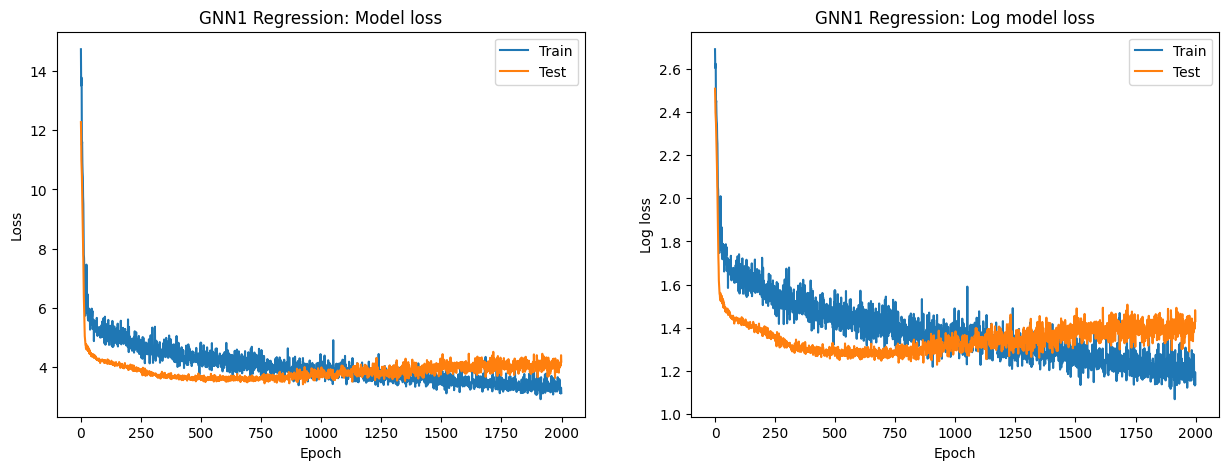

In [16]:
gnn1_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn1_model(v_batch.x.float(), v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn1_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'GNN1 Regression: MSE = {gnn1_mse:.3f}')
plot_history(train_losses, val_losses, 'GNN1 Regression')

In [17]:

class GNN2(nn.Module):
    def __init__(self, input_dim):
        super(GNN2, self).__init__()
        self.conv1 = GATConv(input_dim, 16, heads=2, concat=True)  
        self.conv2 = GATConv(32, 8, heads=2, concat=True)  
        self.conv3 = GATConv(16, 8, heads=1, concat=True)  # Single attention head
        self.fc3 = nn.Linear(8, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x, edge_index, batch):
        x = self.tanh(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.tanh(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.tanh(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        # x = tch.cat([global_mean_pool(x, batch), 
        #             global_max_pool(x, batch)], dim=1)
        x = self.fc3(x)
        return x

In [18]:

gnn2_model = GNN2(input_dim).to(device)
optimizer = optim.Adam(gnn2_model.parameters()
                       , lr=0.0005
                       , weight_decay= weight_decay
                       )  # Adjust learning rate as needed
gnn2_model, train_losses, val_losses = fitGNN(gnn2_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/8 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/2 [00:00<?, ?it/s]

GNN2 Regression: MSE = 2.188


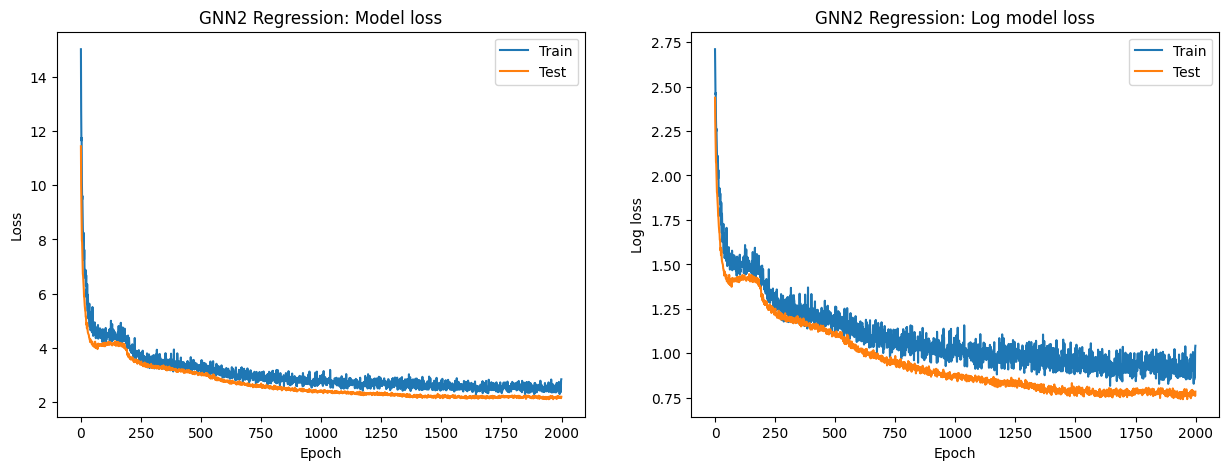

In [19]:
gnn2_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn2_model(v_batch.x, v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn1_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'GNN2 Regression: MSE = {gnn1_mse:.3f}')
plot_history(train_losses, val_losses, 'GNN2 Regression')

In [20]:
class GNN3(nn.Module):
    def __init__(self, input_dim):
        super(GNN3, self).__init__()
        self.conv1 = GATConv(input_dim, 64, heads=2, concat=True)  # Single attention head
        self.conv2 = GATConv(128, 32, heads=2, concat=True)  
        self.conv3 = GATConv(64, 32, heads=1, concat=True)  # Single attention head
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x, edge_index, batch):
        x = self.tanh(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.tanh(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.tanh(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        # x = self.fc3(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [21]:
# Initialize the GNN1 model
num_epochs = 6000
gnn3_model = GNN3(input_dim).to(device)
optimizer = optim.Adam(gnn3_model.parameters()
                       , lr=0.0005
                       , weight_decay= weight_decay
                       )  # Adjust learning rate as needed
gnn3_model, train_losses, val_losses = fitGNN(gnn3_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/8 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/2 [00:00<?, ?it/s]

GNN3 Regression: MSE = 1.496


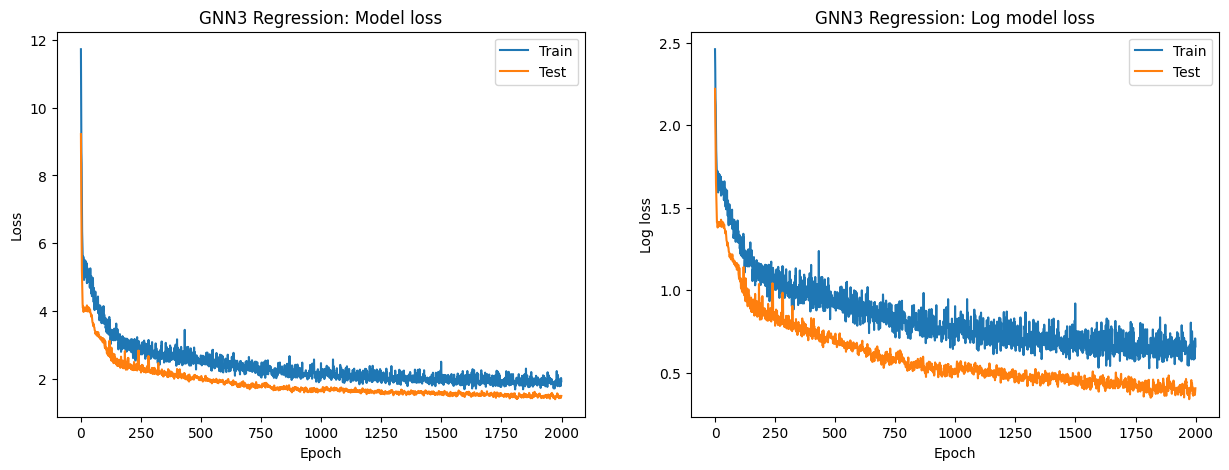

In [22]:
gnn3_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn3_model(v_batch.x, v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn3_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'GNN3 Regression: MSE = {gnn3_mse:.3f}')
plot_history(train_losses, val_losses, 'GNN3 Regression')